In [1]:
import pandas as pd
import netCDF4 
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate
from copulas.multivariate import VineCopula
from copulas.visualization import compare_3d
from copulas.visualization import scatter_3d
from sklearn.preprocessing import MinMaxScaler
from copulas.univariate import GaussianUnivariate
import copulas.bivariate


# Import data

In [ ]:
import cdsapi

client = cdsapi.Client()

variables = [
    "relative_humidity",
    "temperature",
    "v_component_of_wind",
    "u_component_of_wind"
]
years = list(range(2008, 2020))  
# Paramètres communs
dataset = "derived-era5-pressure-levels-daily-statistics"
months = [f"{m:02d}" for m in range(1, 13)]
days = [f"{d:02d}" for d in range(1, 32)]

for variable in variables:
    for year in years:
        request = {
            "product_type": "reanalysis",
            "variable": variable,
            "year": str(year),
            "month": months,
            "day": days,
            "pressure_level": ["1000"],
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "6_hourly",
            "area": [80, -10, 30, 50],
            "format": "netcdf"  
        }

        output_file = f"{variable}_{year}.nc"
        print(f"Téléchargement de {output_file}...")
        client.retrieve(dataset, request).download(output_file)


2025-08-01 12:14:52,897 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Téléchargement de relative_humidity_2008.nc...


2025-08-01 12:14:53,384 INFO Request ID is e6c1064c-9308-4278-b080-81dc866420b0
2025-08-01 12:14:53,489 INFO status has been updated to accepted
2025-08-01 12:15:26,544 INFO status has been updated to running
2025-08-01 12:21:13,493 INFO status has been updated to successful


Téléchargement de relative_humidity_2009.nc...


2025-08-01 12:21:23,629 INFO Request ID is 3fb2a60a-846b-4f3b-b214-b7b6300e3af1
2025-08-01 12:21:23,788 INFO status has been updated to accepted
2025-08-01 12:21:45,710 INFO status has been updated to running
2025-08-01 12:31:45,236 INFO status has been updated to successful


Téléchargement de relative_humidity_2010.nc...


2025-08-01 12:31:51,465 INFO Request ID is 0bf7f85d-2b83-4a57-87a4-cd2501b1d4d2
2025-08-01 12:31:51,602 INFO status has been updated to accepted
2025-08-01 12:32:00,781 INFO status has been updated to running
2025-08-01 12:38:12,603 INFO status has been updated to successful


Téléchargement de relative_humidity_2011.nc...


2025-08-01 12:38:23,955 INFO Request ID is 453f33c3-5650-4e63-918f-df0e24074c60
2025-08-01 12:38:24,080 INFO status has been updated to accepted
2025-08-01 12:38:57,394 INFO status has been updated to running
2025-08-01 12:46:44,621 INFO status has been updated to successful


Téléchargement de relative_humidity_2012.nc...


2025-08-01 12:46:48,525 INFO Request ID is 8af83c2e-8fab-4304-a809-de57f2a657cf
2025-08-01 12:46:48,653 INFO status has been updated to accepted
2025-08-01 12:47:10,514 INFO status has been updated to running
2025-08-01 12:55:10,027 INFO status has been updated to successful


Téléchargement de relative_humidity_2013.nc...


2025-08-01 12:55:15,807 INFO Request ID is 444d62f2-e0de-41d2-a232-29c032ccfb82
2025-08-01 12:55:15,927 INFO status has been updated to accepted
2025-08-01 12:55:24,557 INFO status has been updated to running
2025-08-01 13:01:36,539 INFO status has been updated to successful


Téléchargement de relative_humidity_2014.nc...


2025-08-01 13:01:42,528 INFO Request ID is fc1ccd06-b1f8-4993-b62b-0c5c9e3d3009
2025-08-01 13:01:43,172 INFO status has been updated to accepted
2025-08-01 13:01:51,998 INFO status has been updated to running
2025-08-01 13:08:03,997 INFO status has been updated to successful


Téléchargement de relative_humidity_2015.nc...


2025-08-01 13:08:21,257 INFO Request ID is 0d7e45fb-dcb0-40a9-bea0-e63fbd7e71aa
2025-08-01 13:08:21,375 INFO status has been updated to accepted
2025-08-01 13:08:54,831 INFO status has been updated to running
2025-08-01 13:14:42,107 INFO status has been updated to successful


Téléchargement de relative_humidity_2016.nc...


2025-08-01 13:14:47,486 INFO Request ID is 44253042-35a0-42cd-af95-05812f8f7aa2
2025-08-01 13:14:47,699 INFO status has been updated to accepted
2025-08-01 13:15:01,749 INFO status has been updated to running
2025-08-01 13:21:08,040 INFO status has been updated to successful


Téléchargement de relative_humidity_2017.nc...


2025-08-01 13:21:24,752 INFO Request ID is a77682e7-db1f-44c9-886d-ba796e7a1019
2025-08-01 13:21:24,841 INFO status has been updated to accepted
2025-08-01 13:22:15,568 INFO status has been updated to running
2025-08-01 13:27:45,525 INFO status has been updated to successful


Téléchargement de relative_humidity_2018.nc...


2025-08-01 13:27:54,215 INFO Request ID is 18036165-e606-4480-a775-9b66738c5457
2025-08-01 13:27:54,407 INFO status has been updated to accepted
2025-08-01 13:28:03,553 INFO status has been updated to running
2025-08-01 13:34:16,851 INFO status has been updated to successful


Téléchargement de relative_humidity_2019.nc...


2025-08-01 13:34:35,024 INFO Request ID is b0400a1c-01b6-43d9-8ad4-0e3545d24322
2025-08-01 13:34:35,141 INFO status has been updated to accepted
2025-08-01 13:34:43,984 INFO status has been updated to running
2025-08-01 13:34:49,260 INFO status has been updated to accepted
2025-08-01 13:34:56,971 INFO status has been updated to running
2025-08-01 13:40:55,997 INFO status has been updated to successful


Téléchargement de temperature_2008.nc...


2025-08-01 13:41:00,623 INFO Request ID is 61aaf4ec-8b51-48c3-a62a-9cdcf155a6f0
2025-08-01 13:41:00,758 INFO status has been updated to accepted
2025-08-01 13:41:22,595 INFO status has been updated to running
2025-08-01 13:47:21,566 INFO status has been updated to successful


Téléchargement de temperature_2009.nc...


2025-08-01 13:47:28,729 INFO Request ID is 6429a124-9147-407c-9eb8-e4b8af8c1524
2025-08-01 13:47:28,837 INFO status has been updated to accepted
2025-08-01 13:47:42,871 INFO status has been updated to running
2025-08-01 13:53:49,395 INFO status has been updated to successful


Téléchargement de temperature_2010.nc...


2025-08-01 13:53:55,975 INFO Request ID is 6529efec-f9b0-4f89-8628-23d4bcd82b63
2025-08-01 13:53:56,161 INFO status has been updated to accepted
2025-08-01 13:54:18,239 INFO status has been updated to running
2025-08-01 14:00:17,331 INFO status has been updated to successful


Téléchargement de temperature_2011.nc...


2025-08-01 14:00:28,953 INFO Request ID is 9ca0151c-f92b-45cb-b809-32437c90cb88
2025-08-01 14:00:29,099 INFO status has been updated to accepted
2025-08-01 14:01:02,555 INFO status has been updated to running
2025-08-01 14:06:49,717 INFO status has been updated to successful


Téléchargement de temperature_2012.nc...


2025-08-01 14:06:55,086 INFO Request ID is d692c742-ab3f-4558-9718-8622c60c820e
2025-08-01 14:06:55,220 INFO status has been updated to accepted
2025-08-01 14:09:48,566 INFO status has been updated to running
2025-08-01 14:15:17,329 INFO status has been updated to successful


Téléchargement de temperature_2013.nc...


2025-08-01 14:15:21,424 INFO Request ID is 123f1dee-bb9f-4500-9823-ff19bcba68b4
2025-08-01 14:15:21,539 INFO status has been updated to accepted
2025-08-01 14:15:27,372 INFO status has been updated to running
2025-08-01 14:21:42,417 INFO status has been updated to successful


Téléchargement de temperature_2014.nc...


2025-08-01 14:21:48,632 INFO Request ID is ccdac0f5-5f07-466d-b8e6-1bbb8aed6875
2025-08-01 14:21:48,967 INFO status has been updated to accepted
2025-08-01 14:21:57,779 INFO status has been updated to running
2025-08-01 14:28:09,130 INFO status has been updated to successful


Téléchargement de temperature_2015.nc...


2025-08-01 14:28:14,932 INFO Request ID is 54d03221-d6f7-4451-b465-0f23ddbe1b72
2025-08-01 14:28:15,047 INFO status has been updated to accepted
2025-08-01 14:28:28,855 INFO status has been updated to running
2025-08-01 14:34:35,054 INFO status has been updated to successful


Téléchargement de temperature_2016.nc...


2025-08-01 14:34:42,318 INFO Request ID is a2a8bda6-f8ed-4648-9b6c-9479681856a5
2025-08-01 14:34:42,449 INFO status has been updated to accepted
2025-08-01 14:35:04,180 INFO status has been updated to running
2025-08-01 14:41:03,056 INFO status has been updated to successful


Téléchargement de temperature_2017.nc...


2025-08-01 14:41:11,375 INFO Request ID is b4c7e76c-4e64-4a53-98d9-9a2b3542452e
2025-08-01 14:41:11,572 INFO status has been updated to accepted
2025-08-01 14:41:20,287 INFO status has been updated to running
2025-08-01 14:47:32,575 INFO status has been updated to successful


Téléchargement de temperature_2018.nc...


2025-08-01 14:47:38,646 INFO Request ID is 6aa4c9df-ad01-4091-acc8-dcf33957276c
2025-08-01 14:47:38,754 INFO status has been updated to accepted
2025-08-01 14:47:47,338 INFO status has been updated to running
2025-08-01 14:53:59,474 INFO status has been updated to successful


Téléchargement de temperature_2019.nc...


2025-08-01 14:54:04,293 INFO Request ID is 773d87b1-7827-4561-8170-8ad5f464cfce
2025-08-01 14:54:04,492 INFO status has been updated to accepted
2025-08-01 14:54:55,577 INFO status has been updated to running
2025-08-01 15:02:27,528 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2008.nc...


2025-08-01 15:02:31,064 INFO Request ID is 3605c9cb-5bbd-4e2e-8ca8-bd76241ef016
2025-08-01 15:02:31,170 INFO status has been updated to accepted
2025-08-01 15:02:45,199 INFO status has been updated to running
2025-08-01 15:06:51,675 INFO status has been updated to accepted
2025-08-01 15:08:52,118 INFO status has been updated to running
2025-08-01 15:14:53,494 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2009.nc...


2025-08-01 15:15:06,584 INFO Request ID is 36df6ec4-7df3-4b42-a4fa-e2c9e6733395
2025-08-01 15:15:06,790 INFO status has been updated to accepted
2025-08-01 15:15:57,885 INFO status has been updated to running
2025-08-01 15:23:29,681 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2010.nc...


2025-08-01 15:23:36,235 INFO Request ID is e396a965-2e4f-49e3-9717-b9dfa9fa564f
2025-08-01 15:23:36,439 INFO status has been updated to accepted
2025-08-01 15:26:30,236 INFO status has been updated to running
2025-08-01 15:31:58,185 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2011.nc...


2025-08-01 15:32:06,305 INFO Request ID is 378d2c89-5127-457b-846f-5d33dbd943d2
2025-08-01 15:32:06,405 INFO status has been updated to accepted
2025-08-01 15:32:39,973 INFO status has been updated to running
2025-08-01 15:40:27,565 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2012.nc...


2025-08-01 15:40:41,200 INFO Request ID is 49cf31fb-c82b-4ebc-838c-cde6a4b98b1c
2025-08-01 15:40:41,290 INFO status has been updated to accepted
2025-08-01 15:41:02,965 INFO status has been updated to running
2025-08-01 15:47:01,481 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2013.nc...


2025-08-01 15:47:22,291 INFO Request ID is 65920335-ee64-4d7f-8897-00293ee4efca
2025-08-01 15:47:22,411 INFO status has been updated to accepted
2025-08-01 15:49:18,259 INFO status has been updated to running
2025-08-01 15:55:44,008 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2014.nc...


2025-08-01 15:55:56,217 INFO Request ID is 2f67f7a8-95e8-4795-a7f4-e0627a478782
2025-08-01 15:55:56,348 INFO status has been updated to accepted
2025-08-01 15:56:05,195 INFO status has been updated to running
2025-08-01 15:56:10,450 INFO status has been updated to accepted
2025-08-01 15:56:18,236 INFO status has been updated to running
2025-08-01 16:02:16,811 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2015.nc...


2025-08-01 16:02:43,361 INFO Request ID is c12c7fd2-bf0b-4243-88dd-025f86380584
2025-08-01 16:02:43,468 INFO status has been updated to accepted
2025-08-01 16:02:52,298 INFO status has been updated to running
2025-08-01 16:18:14,708 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2016.nc...


2025-08-01 16:18:20,458 INFO Request ID is 49702e56-30a5-4673-80f5-b1c18fa3e145
2025-08-01 16:18:20,539 INFO status has been updated to accepted
2025-08-01 16:20:15,099 INFO status has been updated to running
2025-08-01 16:26:40,222 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2017.nc...


2025-08-01 16:26:45,989 INFO Request ID is b1b304bc-569d-496d-a703-5d7ee979ffb5
2025-08-01 16:26:46,068 INFO status has been updated to accepted
2025-08-01 16:44:56,966 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2018.nc...


2025-08-01 16:45:12,990 INFO Request ID is 5697fd01-feb4-4be1-a3dc-fe61e1520bab
2025-08-01 16:45:13,173 INFO status has been updated to accepted
2025-08-01 16:53:34,118 INFO status has been updated to running
2025-08-01 16:59:35,158 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2019.nc...


2025-08-01 16:59:49,490 INFO Request ID is c8ef9426-ab7e-4bd9-a36c-eab055bb327b
2025-08-01 16:59:49,628 INFO status has been updated to accepted


In [4]:
import cdsapi

client = cdsapi.Client()

variables = [
    "relative_humidity",
    "temperature",
    "v_component_of_wind",
    "u_component_of_wind"
]

years = list(range(2021, 202))  

dataset = "derived-era5-pressure-levels-daily-statistics"
months = [f"{m:02d}" for m in range(1, 13)]
days = [f"{d:02d}" for d in range(1, 32)]

for variable in variables:
    for year in years:
        request = {
            "product_type": "reanalysis",
            "variable": variable,
            "year": str(year),
            "month": months,
            "day": days,
            "pressure_level": ["1000"],
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "6_hourly",
            "area": [80, -10, 30, 50],
            "format": "netcdf"  
        }

        output_file = f"{variable}_{year}.nc"
        print(f"Téléchargement de {output_file}...")
        client.retrieve(dataset, request).download(output_file)


2025-08-02 19:36:05,271 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Téléchargement de relative_humidity_2021.nc...


2025-08-02 19:36:05,599 INFO Request ID is b84e9a79-e482-4499-a48e-92069f4dafa2
2025-08-02 19:36:05,904 INFO status has been updated to accepted
2025-08-02 19:36:14,814 INFO status has been updated to running
2025-08-02 19:42:26,463 INFO status has been updated to successful


Téléchargement de temperature_2021.nc...


2025-08-02 19:42:47,581 INFO Request ID is 74b2e123-a761-4d46-8160-4bf2ba42d1fb
2025-08-02 19:42:47,694 INFO status has been updated to accepted
2025-08-02 19:42:56,697 INFO status has been updated to running
2025-08-02 19:49:08,246 INFO status has been updated to successful


Téléchargement de v_component_of_wind_2021.nc...


2025-08-02 19:49:22,604 INFO Request ID is 8b05b41e-7f5d-4d5d-8a5a-0ce3e775749e
2025-08-02 19:49:22,687 INFO status has been updated to accepted
2025-08-02 19:49:31,440 INFO status has been updated to running
2025-08-02 19:55:43,342 INFO status has been updated to successful


Téléchargement de u_component_of_wind_2021.nc...


2025-08-02 19:56:01,501 INFO Request ID is 839af427-d264-477a-b917-2c714dd41007
2025-08-02 19:56:01,628 INFO status has been updated to accepted
2025-08-02 19:56:23,508 INFO status has been updated to running
2025-08-02 20:02:21,835 INFO status has been updated to successful


# Explore

In [5]:
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [6]:
netcdf_files

['data\\relative_humidity_2008.nc',
 'data\\relative_humidity_2009.nc',
 'data\\relative_humidity_2010.nc',
 'data\\relative_humidity_2011.nc',
 'data\\relative_humidity_2012.nc',
 'data\\relative_humidity_2013.nc',
 'data\\relative_humidity_2014.nc',
 'data\\relative_humidity_2015.nc',
 'data\\relative_humidity_2016.nc',
 'data\\relative_humidity_2017.nc',
 'data\\relative_humidity_2018.nc',
 'data\\relative_humidity_2019.nc',
 'data\\relative_humidity_2020.nc',
 'data\\relative_humidity_2022.nc',
 'data\\relative_humidity_2023.nc',
 'data\\relative_humidity_2024.nc',
 'data\\temperature_2008.nc',
 'data\\temperature_2009.nc',
 'data\\temperature_2010.nc',
 'data\\temperature_2011.nc',
 'data\\temperature_2012.nc',
 'data\\temperature_2013.nc',
 'data\\temperature_2014.nc',
 'data\\temperature_2015.nc',
 'data\\temperature_2016.nc',
 'data\\temperature_2017.nc',
 'data\\temperature_2018.nc',
 'data\\temperature_2019.nc',
 'data\\temperature_2020.nc',
 'data\\temperature_2022.nc',
 'da

In [7]:
import xarray as xr
import numpy as np
import glob
import dask
rh_files = sorted(glob.glob("data\\relative_humidity*.nc"))
t_files  = sorted(glob.glob("data\\temperature*.nc"))
u_files  = sorted(glob.glob("data\\u_component_of_wind*.nc"))
v_files  = sorted(glob.glob("data\\v_component_of_wind*.nc"))

# 2) Charger chaque série annuelle en un seul Dataset multi-années
dry = xr.open_mfdataset(rh_files, combine="by_coords")
hot  = xr.open_mfdataset(t_files,  combine="by_coords")
wind_u  = xr.open_mfdataset(u_files,  combine="by_coords")
wind_v  = xr.open_mfdataset(v_files,  combine="by_coords")


# 3) Extraire le level = 1000 hPa et renommer
rh1000 = dry["r"].rename("dry")       # humidité relative [%]

t1000 = hot["t"].rename("t_K")              # température [K]

u1000 = wind_u["u"]

v1000 = wind_v["v"]

# 4) Calculs dérivés
t2m_C = (t1000 - 273.15).rename("hot")                           # en °C
wind_speed = np.sqrt(u1000**2 + v1000**2).rename("wind")      # en m/s

# 5) Fusionner les quatre variables en un seul Dataset
ds_all = xr.merge([rh1000, t2m_C, wind_speed])



In [8]:
ds_all

<xarray.Dataset> Size: 4GB
Dimensions:         (pressure_level: 1, latitude: 201, longitude: 241,
                     valid_time: 6210)
Coordinates:
    number          int64 8B 0
  * pressure_level  (pressure_level) float64 8B 1e+03
  * latitude        (latitude) float64 2kB 80.0 79.75 79.5 ... 30.5 30.25 30.0
  * longitude       (longitude) float64 2kB -10.0 -9.75 -9.5 ... 49.5 49.75 50.0
  * valid_time      (valid_time) datetime64[ns] 50kB 2008-01-01 ... 2024-12-31
Data variables:
    dry             (valid_time, pressure_level, latitude, longitude) float32 1GB dask.array<chunksize=(183, 1, 101, 121), meta=np.ndarray>
    hot             (valid_time, pressure_level, latitude, longitude) float32 1GB dask.array<chunksize=(183, 1, 101, 121), meta=np.ndarray>
    wind            (valid_time, pressure_level, latitude, longitude) float32 1GB dask.array<chunksize=(183, 1, 101, 121), meta=np.ndarray>
Attributes: (12/31)
    GRIB_paramId:                             157
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      48441
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           r
    GRIB_totalNumber:                         0
    GRIB_units:                               %
    long_name:                                Relative humidity
    units:                                    %
    standard_name:                            relative_humidity

In [ ]:
df_all = ds_all.squeeze("pressure_level", drop=True)


In [ ]:
df_all = df_all.sel(
    latitude=slice(50.75, 43.25),  
    longitude=slice(-4, 6.25),
)


In [3]:
print(ds_all.latitude.min().item(), ds_all.latitude.max().item())
print(ds_all.longitude.min().item(), ds_all.longitude.max().item())


30.0 60.0
-10.0 20.0


In [ ]:
print(df_all.latitude.min().item(), df_all.latitude.max().item())
print(df_all.longitude.min().item(), df_all.longitude.max().item())


In [20]:
df_all.to_netcdf("output/h_d_w_days.nc")


In [6]:
df_all.to_netcdf("output/h_d_w_days_GCM_agri.nc")


In [2]:
ds_all= xr.open_mfdataset("output/h_d_w_days.nc")


In [13]:
df_ref = pd.DataFrame({
    "latitude": [45.0, 46.0, 47.0],
    "longitude": [5.0, 6.0, 7.0],
    "year": [2020, 2021, 2022]
})


In [14]:
df_ref["latitude"] = df_ref["latitude"].round(2)
df_ref["longitude"] = df_ref["longitude"].round(2)

lats = np.sort(df_ref["latitude"].unique())
lons = np.sort(df_ref["longitude"].unique())



In [ ]:
ds = ds_all.sel(
    latitude=xr.DataArray(lats, dims="latitude"),
    longitude=xr.DataArray(lons, dims="longitude"),
    method="nearest"  # très utile si les coord ne sont pas exactement alignées
)

ds = ds.assign_coords(year=ds["valid_time"].dt.year)

In [18]:

# 4. Calcul des indicateurs binaires
hot_days = (ds["hot"] > 35).astype("int32")
dry_days = (ds["dry"] < 30).astype("int32")
windy_days = (ds["wind"] >= 7).astype("int32")
hdw_days = (hot_days & dry_days & windy_days).astype("int32")

for var in [hot_days, dry_days, windy_days, hdw_days]:
    assert "valid_time" in var.dims, f"{var.name} has incorrect dimensions: {var.dims}"

# 5. Agrégation annuelle (groupby sur coordonnée 'year')
hot_annual = hot_days.groupby(ds["year"]).sum("valid_time")
dry_annual = dry_days.groupby(ds["year"]).sum("valid_time")
wind_annual = windy_days.groupby(ds["year"]).sum("valid_time")
hdw_annual = hdw_days.groupby(ds["year"]).sum("valid_time")


In [19]:
annual_counts = xr.Dataset({
    "hot_days": hot_annual,
    "dry_days": dry_annual,
    "windy_days": wind_annual,
    "hdw_days": hdw_annual,
})

In [20]:

# 6. Conversion en DataFrame
df_hdw = annual_counts.to_dataframe().reset_index()

# 7. Merge avec ta base
df_merged = df_ref.merge(df_hdw, on=["year", "latitude", "longitude"], how="left")


# 🔍 Résultat
print(df_merged.head())

   latitude  longitude  year  number  hot_days  dry_days  windy_days  hdw_days
0      45.0        5.0  2020     0.0       1.0       0.0         1.0       0.0
1      46.0        6.0  2021     NaN       NaN       NaN         NaN       NaN
2      47.0        7.0  2022     0.0       2.0       0.0         0.0       0.0


In [ ]:
df_merged.to_excel("output/hdw_yearly.xlsx")

In [11]:
# df_landes
lat_sel, lon_sel = 44, -0.75
ds_loc = ds_all.sel(latitude=lat_sel, longitude=lon_sel, method="nearest")
df_landes = ds_loc.to_dataframe().reset_index()



In [12]:
# df_algérie
lat_sel, lon_sel =30, 0
ds_loc = ds_all.sel(latitude=lat_sel, longitude=lon_sel, method="nearest")
df_algerie = ds_loc.to_dataframe().reset_index()



In [13]:
# landes
df_landes['HDW'] = (
    (df_landes['hot'] > 35) &
    (df_landes['dry'] < 30) &
    (df_landes['wind'] >= 7)
).astype(int)

print(df_landes[['hot',
'dry','wind','HDW']].head())


         hot        dry       wind  HDW
0  19.909546  38.041851   8.657652    0
1  19.147797  76.587906  11.742547    0
2  15.631042  77.820526   5.025979    0
3  16.095856  97.265579   5.613977    0
4   7.965240  92.100044   4.178476    0


In [14]:
# landes
df_algerie['HDW'] = (
    (df_algerie['hot'] > 35) &
    (df_algerie['dry'] < 30) &
    (df_algerie['wind'] >= 7)
).astype(int)



In [15]:
df_landes.groupby("HDW").count()
# Landes

,pressure_level,valid_time,number,latitude,longitude,dry,hot,wind
HDW,,,,,,,,
0,1096,1096,1096,1096,1096,1096,1096,1096


In [16]:
df_algerie.groupby("HDW").count()
# algérie

,pressure_level,valid_time,number,latitude,longitude,dry,hot,wind
HDW,,,,,,,,
0,1063,1063,1063,1063,1063,1063,1063,1063
1,33,33,33,33,33,33,33,33


In [ ]:
def uniformize_data(df, columns):
    """
    Transforme chaque colonne du DataFrame en pseudo-observations uniformes [0,1]
    Utilisé pour ajuster une copule.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes à transformer.
        columns (list): Liste des noms de colonnes à transformer.

    Returns:
        np.ndarray: Tableau numpy transformé (n, d)
    """
    n = len(df)
    u = np.zeros((n, len(columns)))

    for i, col in enumerate(columns):
        ranks = df[col].rank(method='average')  # méthode 'average' pour être stable
        u[:, i] = ranks / (n + 1)  # normalisation sur [0,1]

    return u

# # Exemple d’utilisation :
# columns = ['dry', 'hot', 'wind']
# df_normalized =pd.DataFrame(uniformize_data(df, columns), columns=columns)


In [173]:

columns = ['dry', 'hot', 'wind']
df_normalized_landes =pd.DataFrame(uniformize_data(df_landes, columns), columns=columns)

In [172]:
columns = ['dry', 'hot', 'wind']
df_normalized_algerie =pd.DataFrame(uniformize_data(df_algerie, columns), columns=columns)

In [174]:
df_normalized_landes.head()

,dry,hot,wind
0,0.002735,0.598906,0.962625
1,0.196901,0.564266,0.994531
2,0.220602,0.374658,0.672744
3,0.867821,0.403829,0.747493
4,0.629900,0.075661,0.540565


# Comptage des HDw

In [19]:
import xarray as xr
import numpy as np
import pandas as pd

# --- 1) Construire l’indicateur HDW ---
hdw = xr.where(
    (ds_all['hot'] > 35) &        # T > 35°C
    (ds_all['dry'] < 30) &        # RH < 30%
    (ds_all['wind'] >= 7),        # vent ≥ 7 m/s
    1, 0
).rename('HDW')

# --- 2) Définir les régions “pays” avec bounding boxes lat/lon ---
regions = {
    'France':    dict(lat=(42, 51), lon=(-5,  9)),
    'Espagne':   dict(lat=(36, 44), lon=(-9,  4)),
    'Italie':    dict(lat=(36, 47), lon=( 6, 19)),
    'Allemagne': dict(lat=(47, 55), lon=( 5, 15)),
    'R.-Uni':    dict(lat=(50, 59), lon=(-8,  2)),
    'Maroc':     dict(lat=(21, 36), lon=(-17, -1)),
    'Algérie':   dict(lat=(19, 37), lon=(-8, 12)),
    'Portugal':  dict(lat=(36.9, 42.1), lon=(-9.5, -6.2)),
    'Croatie':   dict(lat=(42.0, 47.0), lon=(13.5, 19.0)),
    'Grèce':     dict(lat=(34.0, 42.0), lon=(19.0, 28.0)),
}


# --- 3) Calculer fréquence et nombre total de HDW pour chaque région ---
results = []
for name, bbox in regions.items():
    # masque spatial
    mask = (
        (hdw['latitude'] >= bbox['lat'][0]) &
        (hdw['latitude'] <= bbox['lat'][1]) &
        (hdw['longitude'] >= bbox['lon'][0]) &
        (hdw['longitude'] <= bbox['lon'][1])
    )
    mask = mask.broadcast_like(hdw)

    hdw_reg = hdw.where(mask)


    # nombre total d’occurrences HDW (somme des 1)
    total = hdw_reg.sum(dim=('valid_time','latitude','longitude'),
                        skipna=True).values.item()

    results.append((name, int(total)))

# --- 4) Mettre en DataFrame et afficher ---
comptage_HDW = pd.DataFrame(results, columns=['pays','nombre de HDW en 2022, 2023 et 2024'])


In [21]:
comptage_HDW.sort_values("nombre de HDW en 2022, 2023 et 2024").head(10)

,pays,"nombre de HDW en 2022, 2023 et 2024"
3,Allemagne,0
4,R.-Uni,0
8,Croatie,0
0,France,2
7,Portugal,8
9,Grèce,13
1,Espagne,91
2,Italie,150
5,Maroc,11649
6,Algérie,40227


In [209]:
france_mask = (
    (ds_all['latitude'] >= 42) & (ds_all['latitude'] <= 51) &
    (ds_all['longitude'] >= -5) & (ds_all['longitude'] <= 9)
)
france_mask = france_mask.broadcast_like(hdw)

# 2) Ne garder que les jours‐grilles où HDW=1 ET dans la France
hdw_fr = hdw.where(france_mask)
df_events = (
    hdw_fr
      .to_dataframe(name='HDW')   # crée un DF dont l’index est (valid_time, latitude, longitude)
      .reset_index()               # index → colonnes
)

# 3) On filtre pour ne garder que les HDW == 1
df_events = df_events[df_events['HDW'] == 1]

# 4) On ne retient que les colonnes date et coord
df_events = df_events[['valid_time', 'latitude', 'longitude']]

print("Les deux HDW en France")
print(df_events)

Les deux HDW en France
        valid_time  latitude  longitude
1301609 2022-07-18     42.25       -5.0
1301690 2022-07-18     42.00       -5.0


# Copule bivariés

## Algérie, désert

In [229]:
df= df_algerie
df_normalized = df_normalized_algerie

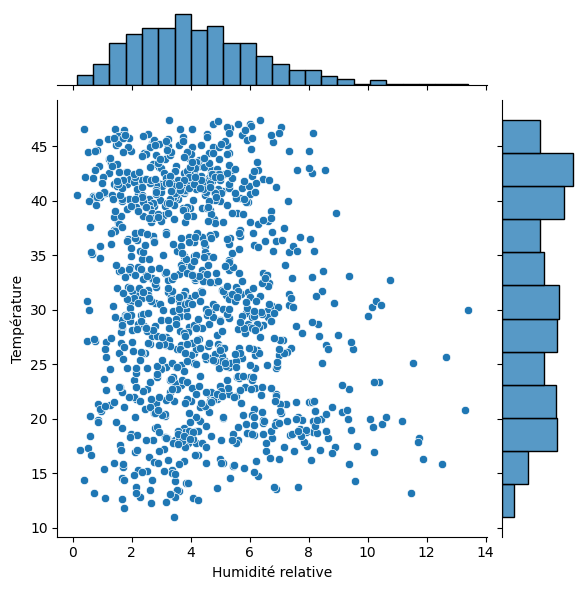

In [ ]:
h = sns.jointplot(x=df.dry, y=df.hot, kind="scatter")
h.set_axis_labels(f"Humidité relative", f"Température", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


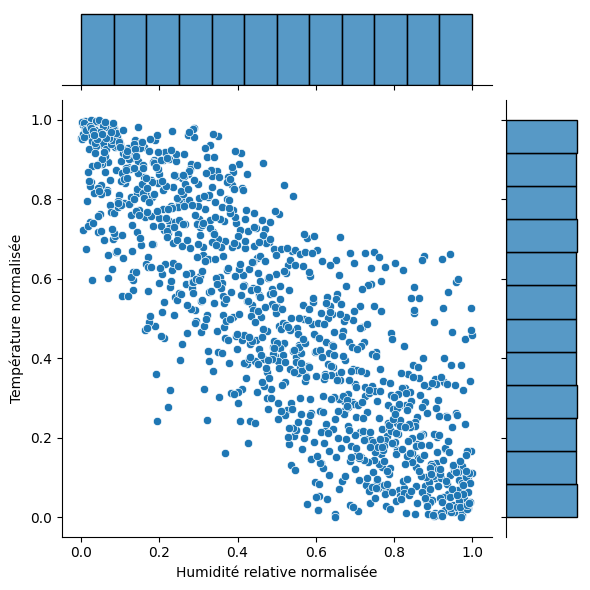

In [177]:
h = sns.jointplot(x=df_normalized.dry, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Humidité relative normalisée", f"Température normalisée", fontsize=10)
# h2.savefig(f"output/distribution_jointe_normalisé_{self.nom_variable1}_{self.nom_variable2}.png")


In [230]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["dry","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-8.885612763761856
1.290460714045053


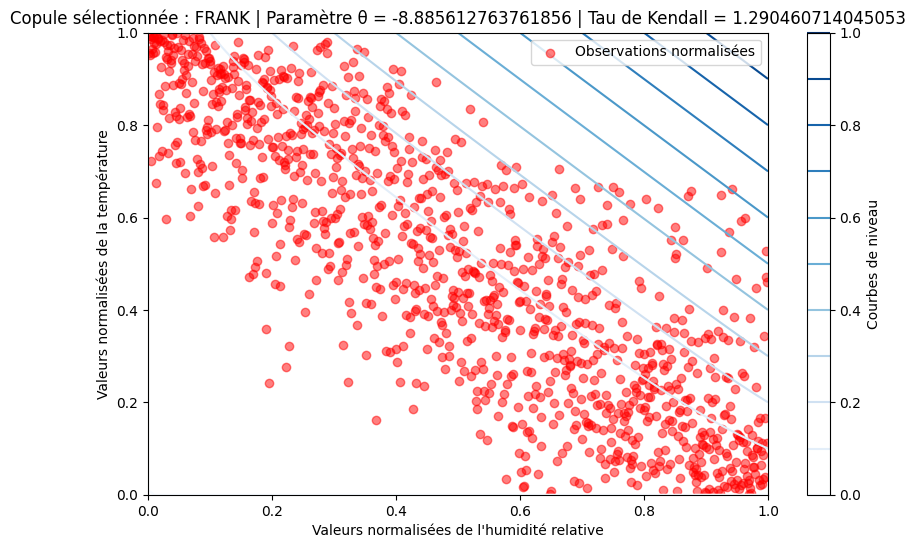

In [231]:
donnees = np.column_stack(
            (df_normalized.dry, df_normalized.hot)
        )
copule_selectionnee.fit(donnees)
u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U, V = np.meshgrid(u, v)
Z = copule_selectionnee.cumulative_distribution(
            np.column_stack((U.ravel(), V.ravel()))
        ).reshape(100, 100)

plt.figure(figsize=(10, 6))
contour = plt.contour(U, V, Z, levels=np.linspace(0, 1, 11), cmap="Blues")
cbar = plt.colorbar(contour)
cbar.set_label("Courbes de niveau")
plt.scatter(
           df_normalized.dry,
            df_normalized.hot,
            c="red",
            label="Observations normalisées",
            alpha=0.5,
        )# Déterminer le contenu du titre dynamiquement
theta_display =theta
tau_display =kendall
titre = (
            f"Copule sélectionnée : {nom_copule} | "
            f"Paramètre θ = {theta_display} | "
            f"Tau de Kendall = {tau_display}"
        )

plt.title(titre)
plt.xlabel(f"Valeurs normalisées de l'humidité relative")
plt.ylabel(f"Valeurs normalisées de la température")
plt.legend()
#plt.savefig(f"output/Copule_{self.nom_copule}_{self.nom_variable1}_{self.nom_variable2}.png")

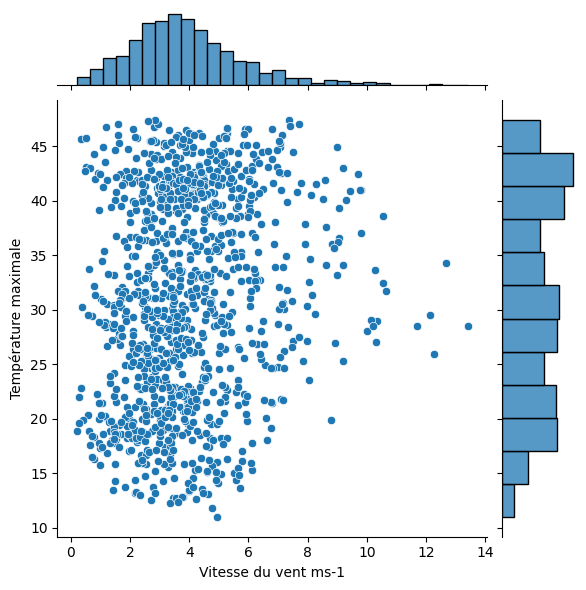

In [180]:
h = sns.jointplot(x=df.wind, y=df.hot, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1", f"Température maximale", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


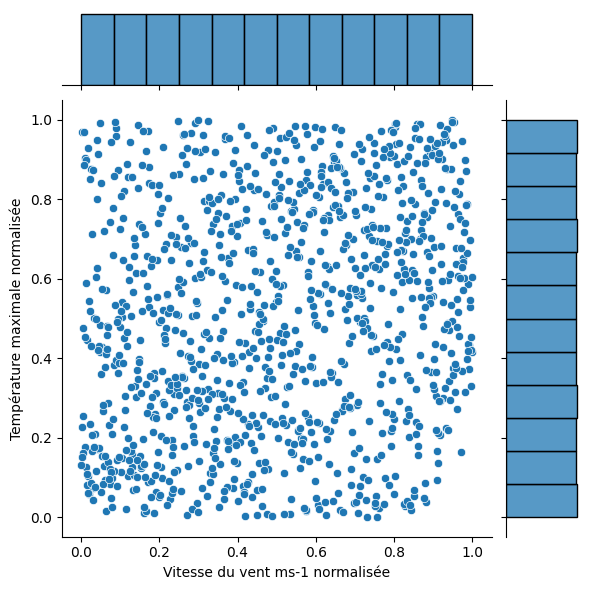

In [181]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1 normalisée", f"Température maximale normalisée", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [182]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
1.2260335394134803
0.38004364320291084


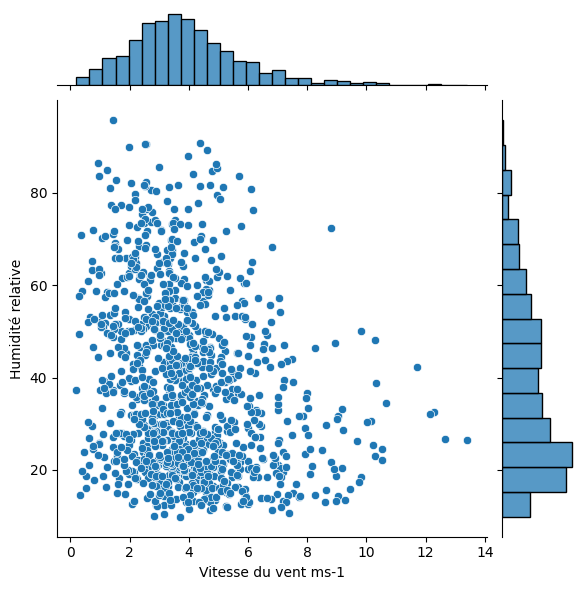

In [183]:
h = sns.jointplot(x=df.wind, y=df.dry, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1", f"Humidité relative", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


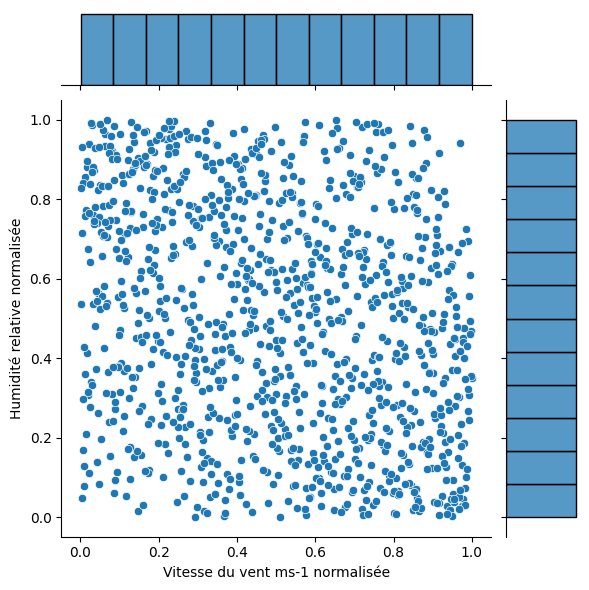

In [184]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.dry, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1 normalisée", f"Humidité relative normalisée", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [185]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","dry"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-1.5742496675964401
-3.697588816217862


## Landes

In [221]:
df_normalized = df_normalized_landes
df = df_landes

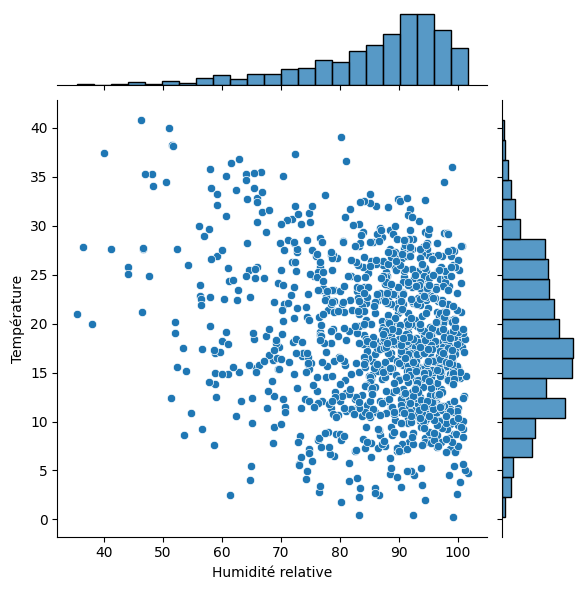

In [222]:
h = sns.jointplot(x=df.dry, y=df.hot, kind="scatter")
h.set_axis_labels(f"Humidité relative", f"Température", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


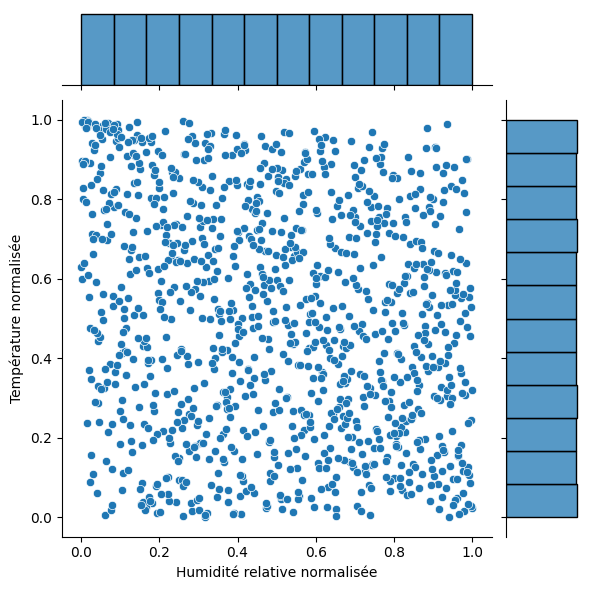

In [153]:
h = sns.jointplot(x=df_normalized.dry, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Humidité relative normalisée", f"Température normalisée", fontsize=10)
# h2.savefig(f"output/distribution_jointe_normalisé_{self.nom_variable1}_{self.nom_variable2}.png")


In [154]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["dry","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-1.191484733535694
-1.47367005046935


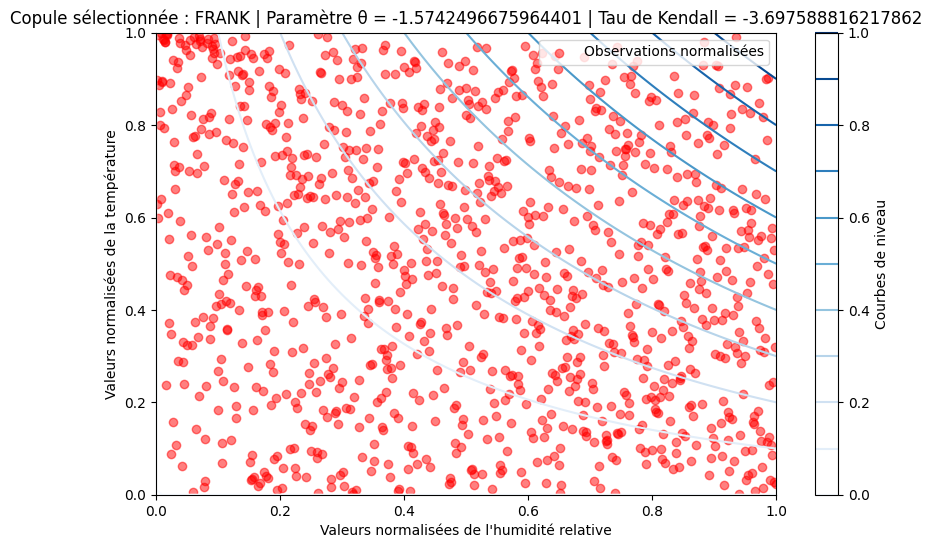

In [223]:
donnees = np.column_stack(
            (df_normalized.dry, df_normalized.hot)
        )
copule_selectionnee.fit(donnees)
u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U, V = np.meshgrid(u, v)
Z = copule_selectionnee.cumulative_distribution(
            np.column_stack((U.ravel(), V.ravel()))
        ).reshape(100, 100)

plt.figure(figsize=(10, 6))
contour = plt.contour(U, V, Z, levels=np.linspace(0, 1, 11), cmap="Blues")
cbar = plt.colorbar(contour)
cbar.set_label("Courbes de niveau")
plt.scatter(
           df_normalized.dry,
            df_normalized.hot,
            c="red",
            label="Observations normalisées",
            alpha=0.5,
        )# Déterminer le contenu du titre dynamiquement
theta_display =theta
tau_display =kendall
titre = (
            f"Copule sélectionnée : {nom_copule} | "
            f"Paramètre θ = {theta_display} | "
            f"Tau de Kendall = {tau_display}"
        )

plt.title(titre)
plt.xlabel(f"Valeurs normalisées de l'humidité relative")
plt.ylabel(f"Valeurs normalisées de la température")
plt.legend()
#plt.savefig(f"output/Copule_{self.nom_copule}_{self.nom_variable1}_{self.nom_variable2}.png")

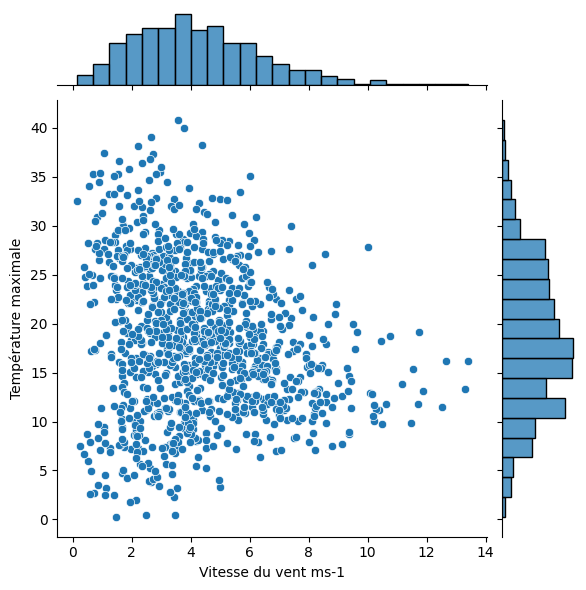

In [156]:
h = sns.jointplot(x=df.wind, y=df.hot, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1", f"Température maximale", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


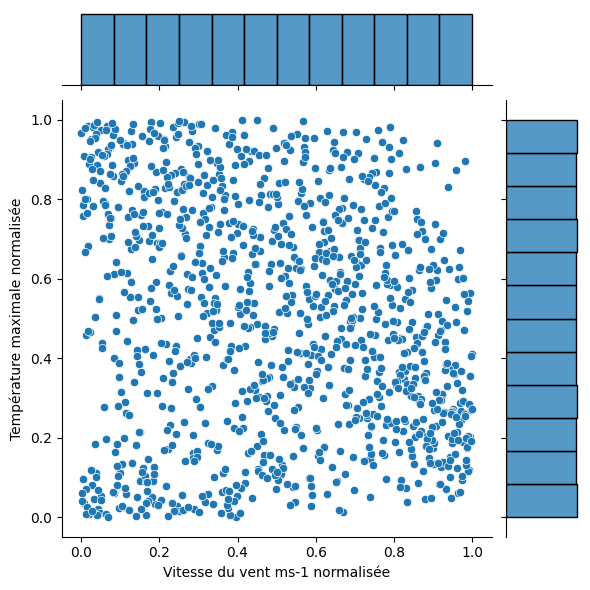

In [157]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.hot, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1 normalisée", f"Température maximale normalisée", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [158]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","hot"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

FRANK
-1.2355286859737817
-1.6161871129822514


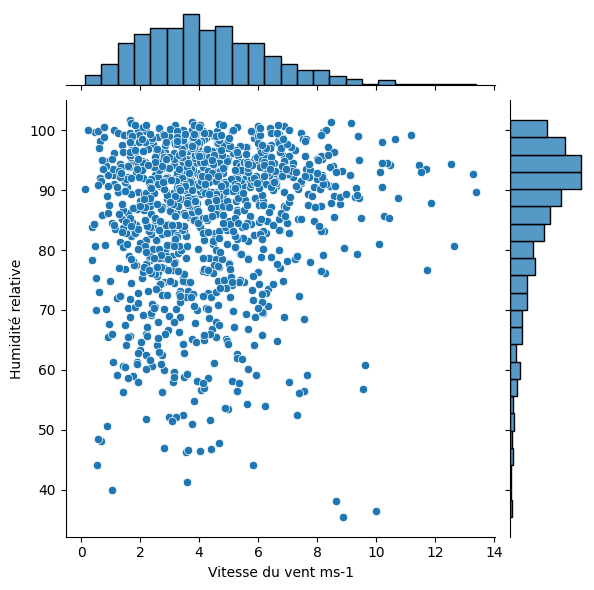

In [159]:
h = sns.jointplot(x=df.wind, y=df.dry, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1", f"Humidité relative", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


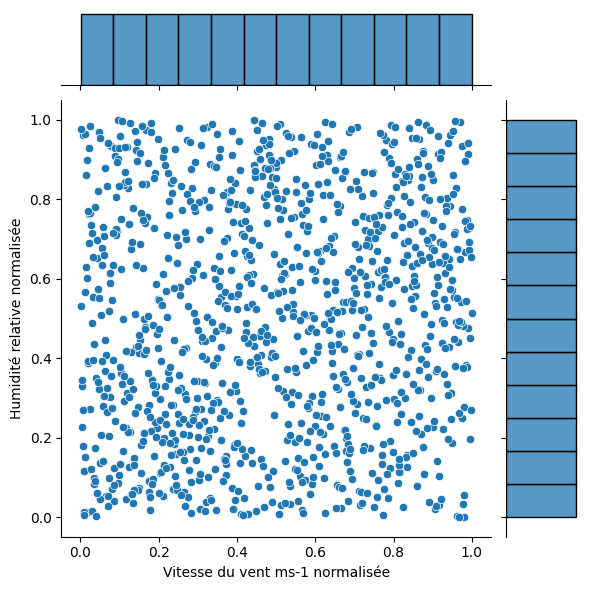

In [160]:
h = sns.jointplot(x=df_normalized.wind, y=df_normalized.dry, kind="scatter")
h.set_axis_labels(f"Vitesse du vent ms-1 normalisée", f"Humidité relative normalisée", fontsize=10)
# return h.savefig(f"output/distribution_jointe_{self.nom_variable1}_{self.nom_variable2}.png")


In [161]:
result = copulas.bivariate.base.Bivariate().select_copula(df_normalized[["wind","dry"]].to_numpy())
copule_selectionnee = result
nom_copule = result.to_dict()["copula_type"]
theta = copule_selectionnee.theta
kendall = theta / (theta + 2)
print(nom_copule)
print(theta)
print(kendall)

CLAYTON
0.13971665852467027
0.06529680365296804


# Copule multivarié

## Algérie, désert

In [215]:
df = df_algerie
df_normalized = df_normalized_algerie

In [216]:

copula = VineCopula("center")
copula.fit(df_normalized)
synthetic_data = copula.sample(len(df_normalized))

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\multivariate\vine.py:78: UserWarning:

Vines have not been fully tested on Python >= 3.8 and might produce wrong results.



In [217]:
copula_params = copula.to_dict()
copula_params.keys()

dict_keys(['type', 'vine_type', 'fitted', 'n_sample', 'n_var', 'depth', 'truncated', 'trees', 'tau_mat', 'u_matrix', 'unis', 'columns'])

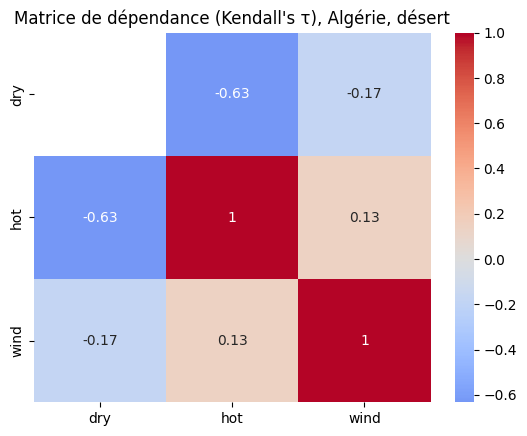

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tau_mat = np.array(copula_params['tau_mat'])
labels = ['dry', 'hot', 'wind']

sns.heatmap(tau_mat, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm', center=0)
plt.title("Matrice de dépendance (Kendall's τ), Algérie, désert")
plt.show()


In [64]:
copula_params['type']

'copulas.multivariate.vine.VineCopula'

In [66]:
df.columns

Index(['pressure_level', 'valid_time', 'number', 'latitude', 'longitude',
       'dry', 'hot', 'wind', 'HDW'],
      dtype='object')

In [219]:
scatter_3d(df[['dry', 'hot', 'wind']])
# scatter_3d(df_normalized)

In [220]:

compare_3d(df_normalized, synthetic_data)

## Landes

In [210]:
df = df_landes
df_normalized= df_normalized_landes

In [162]:

copula = VineCopula("center")
copula.fit(df_normalized)
synthetic_data = copula.sample(len(df_normalized))

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\multivariate\vine.py:78: UserWarning:

Vines have not been fully tested on Python >= 3.8 and might produce wrong results.



In [163]:
copula_params = copula.to_dict()
copula_params.keys()

dict_keys(['type', 'vine_type', 'fitted', 'n_sample', 'n_var', 'depth', 'truncated', 'trees', 'tau_mat', 'u_matrix', 'unis', 'columns'])

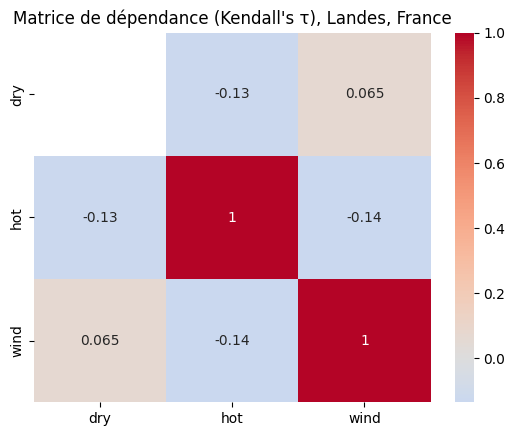

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tau_mat = np.array(copula_params['tau_mat'])
labels = ['dry', 'hot', 'wind']

sns.heatmap(tau_mat, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm', center=0)
plt.title("Matrice de dépendance (Kendall's τ), Landes, France")
plt.show()


In [165]:
copula_params['type']

'copulas.multivariate.vine.VineCopula'

In [166]:
df.columns

Index(['pressure_level', 'valid_time', 'number', 'latitude', 'longitude',
       'dry', 'hot', 'wind', 'HDW'],
      dtype='object')

In [167]:
scatter_3d(df[['dry', 'hot', 'wind']])
# scatter_3d(df_normalized)

In [212]:
scatter_3d(df_normalized[['dry', 'hot', 'wind']])


In [168]:

compare_3d(df_normalized, synthetic_data)